In [287]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from helpers.readers import read_dataframe

# Load datasets and prepare merged dataframes

In [19]:
cmu_movies = read_dataframe(
    name='cmu/movies',
    preprocess=True,
    usecols=[
        "Wikipedia movie ID",
        "Freebase movie ID",
        "Movie name",
        "Movie release date",
        "Movie box office revenue",
        "Movie runtime",
        "Movie languages",
        "Movie countries",
        "Movie genres",
    ]
)
imdb_info = read_dataframe(name='imdb/movies', preprocess=True)
imdb_ratings = read_dataframe(name='imdb/ratings')
movieLens_movies = read_dataframe(name='movieLens/movies', preprocess=True)
movieLens_ratings = read_dataframe('movieLens/ratings')

imdb_crew = read_dataframe(name='imdb/crew')
imdb_people = read_dataframe(name='imdb/names')
imdb_principals = read_dataframe(name='imdb/principals')

Preprocess logs:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
Preprocess logs:
✅ Moved genres from runtimeMinutes to genres column
Preprocess logs:
✅ Aligned bad rows


## Prepare the movies dataframe

In [13]:
mapping_w_i_f = read_dataframe(name='mapping_wikipedia_imdb_freebase')
mapping_f_i = read_dataframe(name='mapping_freebase_imdb')

In [601]:
movies = cmu_movies.drop(['Movie release Day', 'Movie release Month'], axis=1).copy()

In [602]:
movies.rename(
    columns={
        'Wikipedia movie ID': 'wikipediaID',
        'Freebase movie ID': 'freebaseID',
        'Movie name': 'title',
        'Movie box office revenue': 'revenue',
        'Movie runtime': 'runtime',
        'Movie languages': 'languages',
        'Movie countries': 'countries',
        'Movie genres': 'genres',
        'Movie release Year': 'release',
    },
    inplace=True,
)

In [603]:
movies = movies.merge(
    right=mapping_f_i.drop_duplicates(subset='freebase'),
    left_on='freebaseID', right_on='freebase', how='left'
).rename(columns={'imdb': 'tconst'}).drop('freebase', axis=1)

In [604]:
movies.tconst.duplicated().sum()
movies.drop_duplicates(subset='tconst', inplace=True)

In [605]:
movies = movies.merge(
    right=imdb_info.rename(columns={'genres': 'genres_imdb', 'runtimeMinutes': 'runtime_imdb'})[['tconst', 'isAdult', 'runtime_imdb', 'genres_imdb']],
    on='tconst', how='left',
)

In [606]:
movies = movies.merge(
    right=imdb_ratings.rename(columns={'averageRating': 'rating', 'numVotes': 'votes'}),
    on='tconst', how='left',
)

In [262]:
# NOTE: Only adds ratings for 100 movies, not worth it

# movies = movies.merge(
#     right=movieLens_movies[['vote_average', 'vote_count', 'imdb_id']].rename(columns={'vote_average': 'rating_lens', 'vote_count': 'votes_lens', 'imdb_id': 'tconst'}),
#     on='tconst', how='left',
# )
# movies.rating_lens.replace(to_replace=0, value=pd.NA)

In [689]:
movies = movies.merge(right=imdb_crew.drop('writers', axis=1), on='tconst', how='left')

## Prepare the directors dataframe

In [727]:
nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

print(f'We have {len(nmconsts)} directos.')

We have 28498 directos.


In [730]:
directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()

# Get more insights on what we have

In [735]:
directors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28498 entries, 4 to 12887194
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   nconst             28498 non-null  string
 1   primaryName        28498 non-null  string
 2   birthYear          15421 non-null  Int16 
 3   deathYear          7214 non-null   Int16 
 4   primaryProfession  28497 non-null  string
 5   knownForTitles     28484 non-null  string
dtypes: Int16(2), string(4)
memory usage: 1.3 MB


In [228]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73749 entries, 0 to 73748
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   wikipediaID   73749 non-null  int32  
 1   freebaseID    73749 non-null  string 
 2   title         73749 non-null  string 
 3   revenue       8327 non-null   float64
 4   runtime       56855 non-null  float32
 5   release       68750 non-null  Int16  
 6   languages     73749 non-null  string 
 7   countries     73749 non-null  string 
 8   genres        73749 non-null  string 
 9   tconst        73748 non-null  string 
 10  isAdult       73736 non-null  Int16  
 11  runtime_imdb  68164 non-null  Int32  
 12  genres_imdb   71965 non-null  string 
 13  rating        67849 non-null  float32
 14  votes         67849 non-null  float64
dtypes: Int16(2), Int32(1), float32(2), float64(2), int32(1), string(7)
memory usage: 6.7 MB


Usable information to popularity and success are: `revenue`, `rating`, and `votes`.

> Awards and nominations can be extracted by scraping IMDb. [Example](https://www.imdb.com/title/tt1302006/awards/) for awards of The Irishman. 

> The same thing can be done for directors but we would need to also generate mappings of FreebaseID to IMDb IDs of the directors.

> There is also a scraped dataset for The Oscar awards and nominations since 1927 on [Kaggle](https://www.kaggle.com/datasets/unanimad/the-oscar-award).

We have to rely on the ratings and votes, so let's dive into it and get some info.
However, it might be unfair to treat movies from all countries the same. Hollywood and Bollywood movies have usually a larger audience, for insntance.


In [304]:
countries = []
for item in movies.countries.str.split(','):
    countries.extend(item)
countries = set(countries)

print(f'We have movies from {len(countries)} countries in the world.')

ratings_countries = movies[['tconst', 'rating', 'votes', 'countries']].copy()
for country in countries:
    if country == '': continue
    contained = ratings_countries.countries.str.contains(country)
    if contained.sum() > 50:
        ratings_countries[country] = ratings_countries.countries.str.contains(country)
ratings_countries.drop('countries', axis=1, inplace=True)

We have movies from 146 countries in the world.


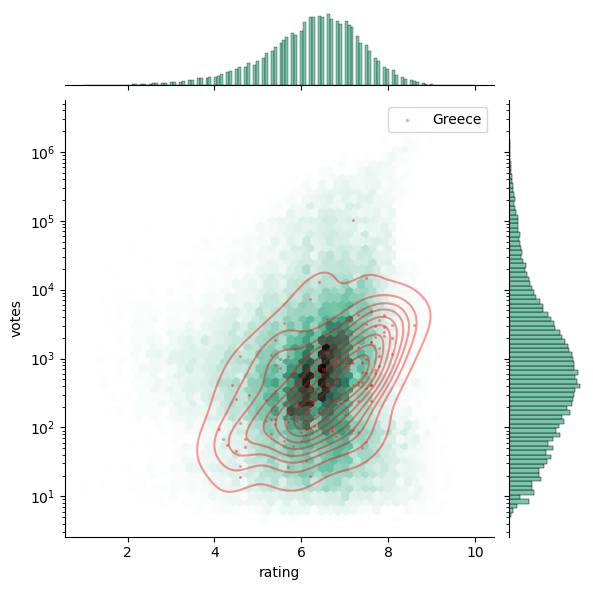

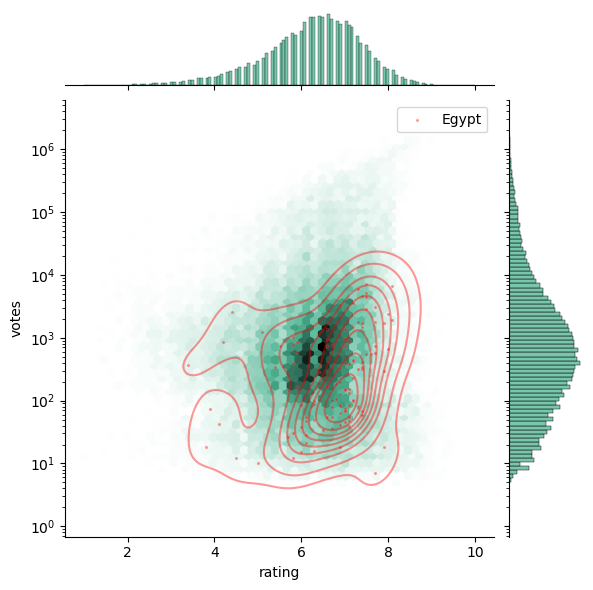

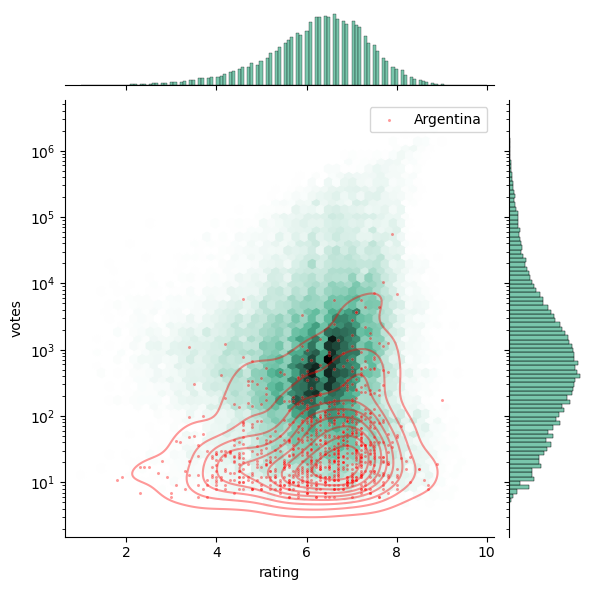

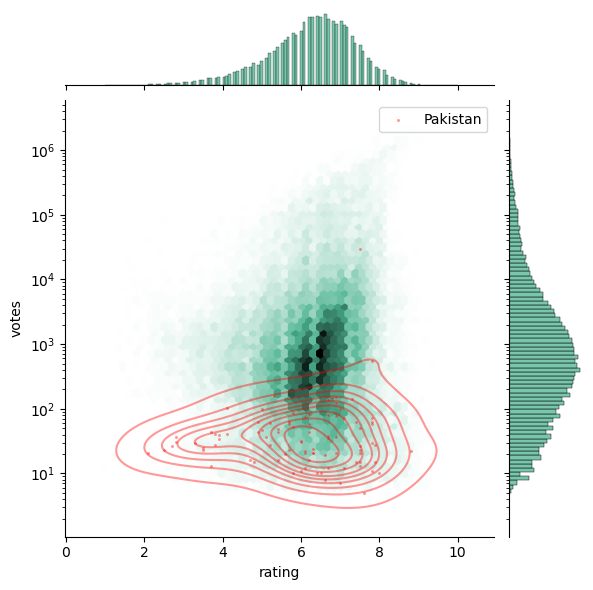

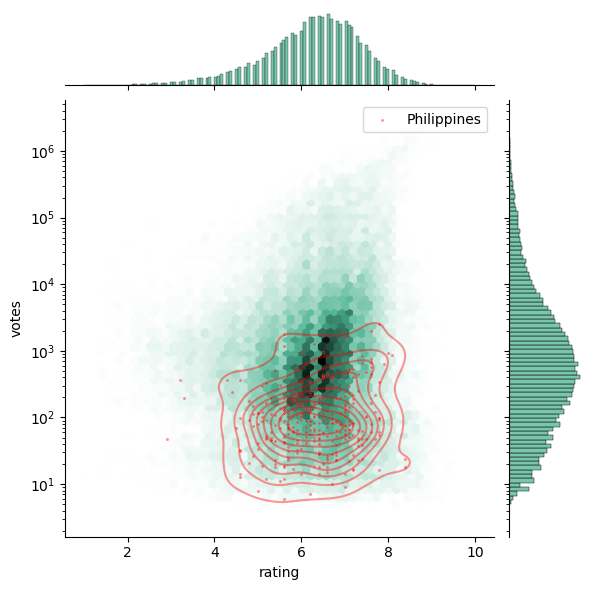

In [948]:
# NOTE: This can be an interactive plot in the final data story

for country in ['Greece', 'Egypt', 'Argentina', 'Pakistan', 'Philippines']:
    if country not in ratings_countries:
        continue
    g = sns.jointplot(x=movies.rating, y=movies.votes, kind='hex', color="#4CB391", joint_kws={'yscale': 'log'})
    df = movies[movies.countries.str.contains(country) & ~movies.countries.str.contains(',')]
    sns.scatterplot(x=df.rating, y=df.votes, color='r', alpha=.4, s=5, ax=g.ax_joint, label=country)
    sns.kdeplot(x=df.rating, y=df.votes, color='r', alpha=.4, ax=g.ax_joint)
    g.ax_joint.legend()

# Define and assess a metric for movie success

Intuitively, number of votes shows the popularity of the movie, and the average rating shows a mix of its quality and its popularity.

Since we have only partial info about the revenue and awards, we can use them for assessing our metrics.

In [608]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

## Check top movies per country

In [609]:
def list_top_movies(country: str, top=10):
    cols = ['title', 'score', 'rating', 'votes', 'revenue', 'release', 'genres']
    display(movies[movies.countries.str.contains(country)].sort_values(by='score', ascending=False)[:top][cols])

In [610]:
list_top_movies('Iran', top=10)

,title,score,rating,votes,revenue,release,genres
73322,A Separation,44.848721,8.3,253198.0,NaN,2011,Drama
6028,Children of Heaven,40.132846,8.2,78388.0,1628579.0,1997,"Family Film,Drama,Adventure,World cinema,Comedy"
21729,About Elly,37.510196,7.9,55992.0,1350000.0,2009,"Mystery,Drama,World cinema"
62963,Marmoulak,36.448384,8.4,21832.0,NaN,2004,Comedy
1086,Close-up,35.589689,8.2,21888.0,NaN,1990,"Crime Fiction,Drama,World cinema,Documentary"
33473,Taste of Cherry,34.945468,7.7,34544.0,NaN,1997,"Drama,World cinema"
34947,Turtles Can Fly,34.475849,8.0,20393.0,NaN,2004,"Drama,Childhood Drama,World cinema,War film"
36774,The Color of Paradise,34.452236,8.1,17921.0,NaN,2000,"Family Drama,Drama,Childhood Drama,World cinema"
20292,Where Is the Friend's Home?,34.331630,8.1,17317.0,NaN,1987,"Drama,Childhood Drama"
35913,F for Fake,32.734615,7.7,17834.0,NaN,1973,"Biography,Film,Experimental film,Documentary,A..."


> Almost all of them are great movies. Having the ones with rates `7.7` and `7.9` at top is a good sign because they are kinda underrated imo.

In [611]:
list_top_movies('United States', top=20)

,title,score,rating,votes,revenue,release,genres
23775,The Shawshank Redemption,59.965840,9.3,2805044.0,2.834147e+07,1994,"Crime Fiction,Buddy film,Prison film,Drama,Esc..."
34376,The Dark Knight,58.005896,9.0,2786760.0,1.004558e+09,2008,"Crime Fiction,Thriller,Superhero movie,Crime D..."
32799,The Godfather,57.877736,9.2,1954602.0,2.685000e+08,1972,"Crime Fiction,Gangster Film,Crime Drama,Family..."
72995,The Lord of the Rings: The Return of the King,56.550332,9.0,1920305.0,1.119930e+09,2003,"Fantasy Adventure,Adventure,Epic,Action/Advent..."
59828,Pulp Fiction,56.361239,8.9,2151413.0,2.139288e+08,1994,"Crime Fiction,Thriller,Crime Comedy,Indie,Gang..."
54352,Inception,56.261196,8.8,2473532.0,8.255328e+08,2010,"Thriller,Science Fiction,Adventure,Psychologic..."
29558,Fight Club,55.880984,8.8,2239297.0,1.009000e+08,1999,"Thriller,Action/Adventure,Existentialism,Psych..."
58894,Forrest Gump,55.784213,8.8,2183308.0,6.773877e+08,1994,"Coming of age,Comedy film,Drama,War film,Roman..."
72163,The Lord of the Rings: The Fellowship of the Ring,55.349406,8.8,1948521.0,8.715303e+08,2001,"Fantasy Adventure,Adventure,Epic,Fantasy,Film ..."
22886,Schindler's List,55.343463,9.0,1410177.0,3.213063e+08,1993,"Tragedy,Biography,History,War film,Biopic [fea..."


> Not bad.

In [612]:
list_top_movies('France', top=20)

,title,score,rating,votes,revenue,release,genres
42499,Terminator 2: Judgment Day,52.101748,8.6,1143780.0,519843345.0,1991,"Thriller,Science Fiction,Doomsday film,Action/..."
54533,Inglourious Basterds,51.948135,8.4,1528629.0,320389438.0,2009,"Thriller,Black comedy,Action/Adventure,Drama,W..."
23325,Léon: The Professional,51.707975,8.5,1211410.0,45284974.0,1994,"Thriller,Crime Fiction,Buddy film,Indie,World ..."
64686,City of God,50.685414,8.6,782803.0,30641770.0,2002,"Crime Fiction,Thriller,Gangster Film,World cin..."
34517,Intouchables,50.611053,8.5,899998.0,NaN,2011,"Biographical film,Drama,Comedy film"
8945,The Pianist,50.528476,8.5,880089.0,120072577.0,2002,"History,Biographical film,Drama,War film"
46093,Amélie,48.900780,8.3,779220.0,173921954.0,2001,"Romantic comedy,World cinema,Fantasy,Comedy,Dr..."
23451,Casino,47.047697,8.2,546417.0,116112375.0,1995,"Crime Fiction,Biography,Gangster Film,Period p..."
36718,Nuovo Cinema Paradiso,46.226951,8.5,274451.0,11990401.0,1988,Drama
43602,Taken,45.189687,7.8,621655.0,226830568.0,2009,"Thriller,Crime Fiction,Psychological thriller,..."


## Check correlation of the scores with other movie characteristics

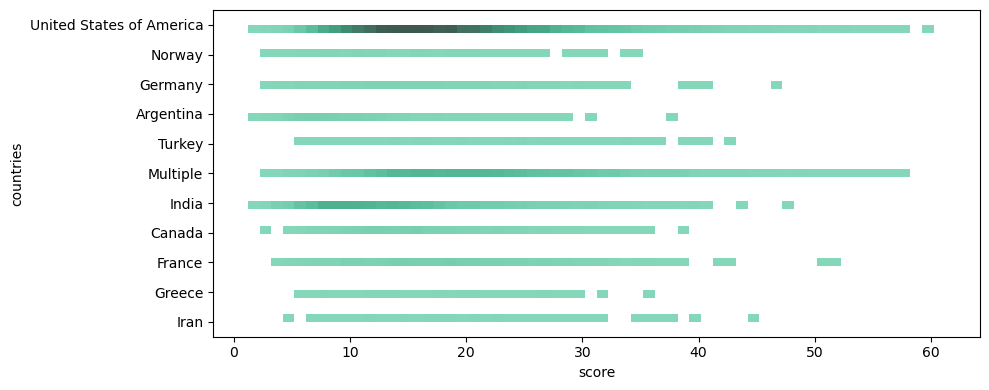

In [648]:
countries = ['United States of America', 'India', 'Turkey', 'France', 'Multiple', 'Germany', 'Norway', 'Greece', 'Canada', 'Argentina', 'Iran']
df = movies.copy()
df.loc[movies.countries.str.contains(','), 'countries'] = 'Multiple'
df = df[df.countries.isin(countries)]

fig, ax = plt.subplots(figsize=(10, 4))
g = sns.histplot(
    ax=ax,
    data=df,
    x='score',
    y='countries',
    discrete=(True, False),
    color='#4CB391'
)
plt.tight_layout()

/var/folders/rw/zplflm8s0mg64xxntr1x_bdr0000gn/T/ipykernel_7611/500197204.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  data=movies.dropna(subset='release').query('release > 1500'),


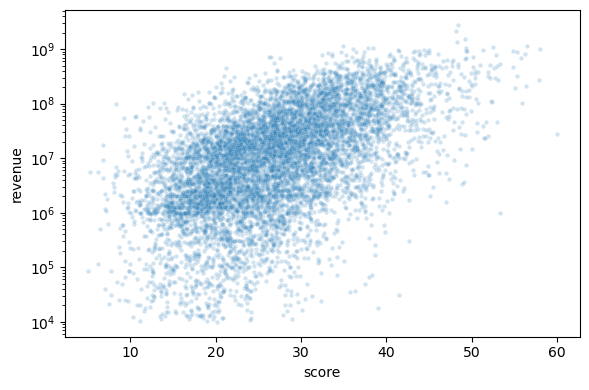

In [678]:
fig, ax = plt.subplots(figsize=(6, 4))
g = sns.scatterplot(
    ax=ax,
    data=movies.dropna(subset='release').query('release > 1500'),
    x='score',
    y='revenue',
    s=10,
    alpha=.2,
    # discrete=(False, True),
)
ax.set(yscale='log')
plt.tight_layout()

/var/folders/rw/zplflm8s0mg64xxntr1x_bdr0000gn/T/ipykernel_7611/2159670855.py:4: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  data=movies.dropna(subset='release').query('release > 1500'),


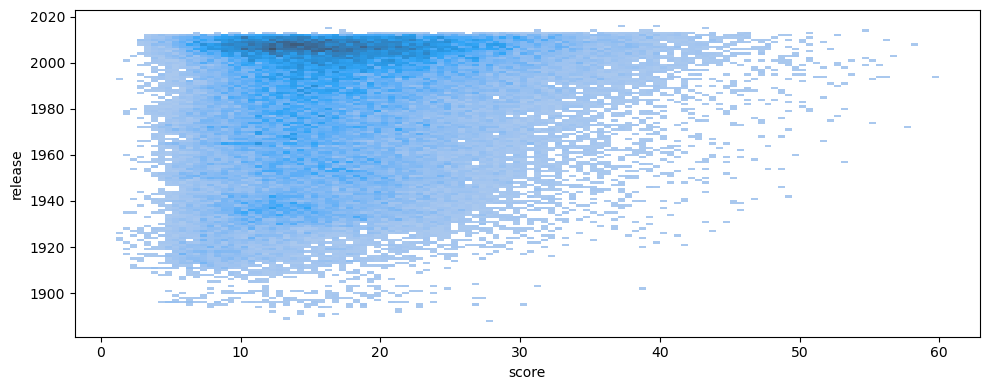

In [649]:
fig, ax = plt.subplots(figsize=(10, 4))
g = sns.histplot(
    ax=ax,
    data=movies.dropna(subset='release').query('release > 1500'),
    x='score',
    y='release',
    discrete=(False, True),
)
plt.tight_layout()

# Define and assess a metric for director success

We can count the number of movies with scores higher than a threshold.

We can probably be more fair to directors from countries with smaller audiences by only considering the rating and apply a threshold on the number of votes.

We can also get the average score of the top movies of the directos.

In [804]:
def metric(director):
    directed_movies = movies[movies.directors.str.contains(director.nconst)]
    score = {
        'hits-30': (directed_movies.score > 30).sum(),
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score

directors['score'] = directors.apply(metric, axis=1)

In [813]:
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

directors.drop('score', axis=1, inplace=True)

Let's check some names:

In [845]:
directors.sort_values(by='avg-5', ascending=False)[:10].drop(['primaryProfession', 'knownForTitles'], axis=1)

,nconst,primaryName,birthYear,deathYear,hits-30,hits-40,hits-45,hits-50,rate-7.0,rate-7.5,rate-8.0,rate-8.5,avg-3,avg-5,avg-10
598226,nm0634240,Christopher Nolan,1970,<NA>,9,7,7,7,10,8,7,4,56.359359,54.76424,48.277678
232,nm0000233,Quentin Tarantino,1963,<NA>,11,8,7,4,10,9,7,2,53.710729,52.175466,47.488598
228,nm0000229,Steven Spielberg,1946,<NA>,25,13,7,3,21,15,7,2,52.930622,51.378904,48.343442
216,nm0000217,Martin Scorsese,1942,<NA>,25,10,7,4,33,22,12,3,51.938314,50.997257,47.283685
115,nm0000116,James Cameron,1954,<NA>,8,6,5,1,8,7,3,1,49.961564,49.2563,41.656368
39,nm0000040,Stanley Kubrick,1928,1999,11,9,5,1,11,11,7,0,49.593339,49.043534,45.40516
398,nm0000399,David Fincher,1962,<NA>,9,7,4,2,7,7,2,2,51.770668,49.031727,<NA>
1390,nm0001392,Peter Jackson,1961,<NA>,9,4,3,3,8,4,3,3,55.600284,48.992753,40.917419
337,nm0000338,Francis Ford Coppola,1939,<NA>,10,4,3,2,10,6,4,3,54.015733,48.884288,42.252444
708,nm0000709,Robert Zemeckis,1952,<NA>,14,8,3,2,8,6,2,2,50.947567,47.926824,43.218293


Let's check these metrics for oscar nominees:

In [827]:
oscars = pd.read_csv('data/the_oscar_award.csv')
oscars = oscars.query('year_film <= 2016')
oscars_directors = oscars[oscars.category.str.contains('DIRECTING')]
directors['oscars_nominated'] = directors.apply(lambda d: (oscars_directors.name == d.primaryName).sum(), axis=1)
directors['oscars_won'] = directors.apply(lambda d: (oscars_directors.query('winner == True').name == d.primaryName).sum(), axis=1)

`avg-3` and `avg-5` seem to be more robust but there are too many missing values. We can go on but we will be left with 6k directors out of 28k.

There are 21988 missing scores (avg-3).


<Axes: xlabel='oscars_nominations', ylabel='avg-3'>

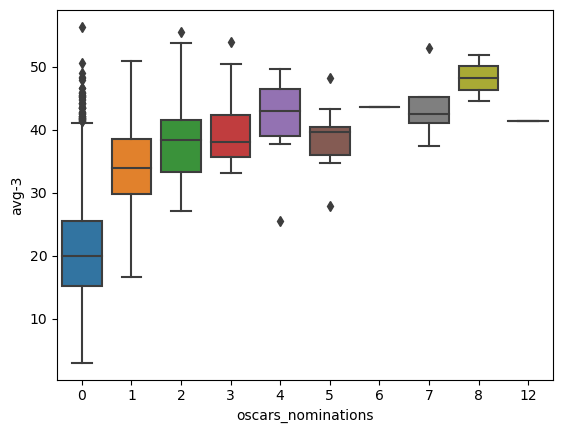

In [919]:
score = 'avg-3'

print(f'There are {directors[score].isna().sum()} missing scores ({score}).')

sns.boxplot(
    y=directors.dropna(subset=score)[score],
    x=(directors.oscars_nominations),
)

`rate-7.0` and `rate-7.5` are also informative and there are no missing values but there seems to be no advantage of using these scores for determining successful directors because:

In [936]:
print(f'There are only {(directors["rate-7.0"] > 2).sum()} directors with at least three movie with rate > 7.0.')

print(f'{directors[directors["rate-7.0"] > 2]["avg-3"].isna().sum()} of these directors miss the avg-3 score.')

There are only 984 directors with at least three movie with rate > 7.0.
0 of these directors miss the avg-3 score.


`hits-40`, `hits-45` and `hits-50` can be used for detecting very few legendary directors.

<Axes: xlabel='hits-40', ylabel='avg-3'>

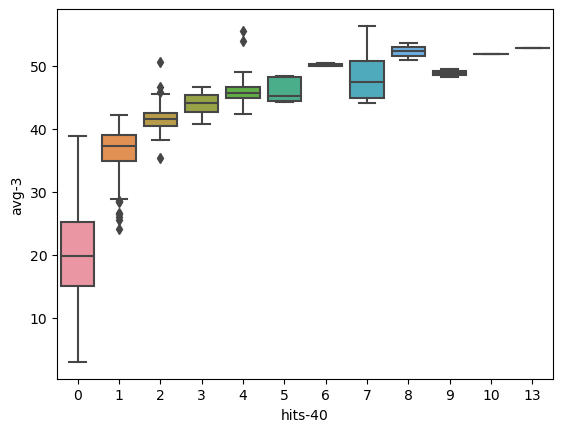

In [939]:
score = 'avg-3'
sns.boxplot(
    y=directors.dropna(subset=score)[score],
    x=(directors['hits-40']),
)

In [947]:
print(f'There are only {(directors["hits-40"] > 0).sum()} directors with at least one hit.')

There are only 420 directors with at least one hit.
